#Importação das bibliotecas e defiição das subrotinas

In [ ]:
!pip install mlflow --quiet
!pip install pyngrok --quiet
!pip install deslib --quiet

import numpy as np
import seaborn as sns
import pandas as pd
import pprint
import mlflow.sklearn

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import NearMiss
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

import mlflow
from pyngrok import ngrok

from deslib.dcs import OLA, LCA, MCB
from deslib.des import KNORAE, KNORAU

import warnings
warnings.filterwarnings("ignore")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [ ]:
#Função que calcula todas as métricas e as retorna no formato de dicionário
def metrics_dict(trained_model, x_test, y_test):
  resultados = trained_model.predict(x_test)
  metricas = {}
  metricas["accuracy"] = metrics.accuracy_score(y_test, resultados)
  tn, fp, fn, tp = confusion_matrix(y_test, resultados).ravel()
  metricas["precision"] = tp / (tp + fp)
  metricas["recal"] = tp / (tp + fn)
  metricas["specificity"] = tn / (tn + fp)
  metricas["auc"] = metrics.roc_auc_score(y_test, resultados)

  return metricas

#Função que instancia um modelo baseado no tipo informado e retorna o modelo instanciado
def instance_model(tipe, params):
  match tipe:
    case 1:
      return DecisionTreeClassifier(**params)
    case 2:
      return KNeighborsClassifier(**params)
    case 3:
      return SVC(**params)
    case 4:
      return GradientBoostingClassifier(**params)
    case 5:
      return xgb.XGBClassifier(**params)
    case 6:
      return lgb.LGBMClassifier(**params)
    case 7:
      return RandomForestClassifier(**params)
    case 8:
      return BaggingClassifier(**params)

In [ ]:
#Função que atualiza os valores das médias das métricas dos modelos
def update_metrics(models_dict, models_instances, x_test, test_y, models_names):
  #metricas dos modelos
  metrics_results = [metrics_dict(model, x_test, test_y) for model in models_instances]

  #Incremento dos valores calculados divididos por 10
  for metrica in metrics_tupla:
    for j,model in enumerate(models_names):
      models_dict[model]["metrics"][metrica] += metrics_results[j][metrica]/10

  return models_dict

# Superfunção que realiza a parte principal Projeto trabanhando em conjutno com as outras funções
def super_function (models_dict, models_names, deslib_models, x_train, train_y, x_test, test_y):

  for i in range(folds):

    #Lista para guardar os modelos instanciados
    models_instances = []

    if (deslib_models == False):
      #Instanciando os modelos
      for model in models_names:
        models_instances.append(instance_model(models_dict[model].get("type"), models_dict[model].get("params")))

      #Treinamentos dos modelos
      for model in models_instances:
        model.fit(x_train[i], train_y[i])

    else:
      #Instancia do modelo RandomForest or Bagging
      aux_model = instance_model(models_dict[models_names[0]].get("type"), models_dict[models_names[0]].get("params"))
      aux_model.fit(x_train[i], train_y[i])
      models_instances.append(aux_model)

      #Separação dos conjuntos de testes para os modelos de seleção dinâmica
      x_drop, x_dsel, y_drop, y_dsel = train_test_split(x_train[i], train_y[i], test_size = 0.5, stratify=train_y[i])

      #Instancia dos modelos de seleção dinâmica
      models_instances.append(KNORAE(aux_model, k = 5).fit(x_dsel, y_dsel))
      models_instances.append(KNORAU(aux_model, k = 5).fit(x_dsel, y_dsel))
      models_instances.append(OLA(aux_model, k = 5).fit(x_dsel, y_dsel))
      models_instances.append(LCA(aux_model, k = 5).fit(x_dsel, y_dsel))
      models_instances.append(MCB(aux_model, k = 5).fit(x_dsel, y_dsel))

    #atualização das médias das metricas de todos os modelos
    models_dict = update_metrics(models_dict, models_instances, x_test[i], test_y[i], models_names)

  #Guarda a última instancia de cada modelo no dicionario models_dicts
  for pos,model in enumerate(models_names):
    models_dict[model]["model"] = models_instances[pos]

  return models_dict


#Importação da Base de dados e Preprocessamento

In [ ]:
###Para saber mais sobre o projeto
###LINK DO KAGGLE https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction

url = "https://raw.githubusercontent.com/Matheus256/Capacitacao_IA_Softex/main/Churn_Modelling.csv"

#dataset = pd.read_csv("Churn_Modelling.csv")
dataset = pd.read_csv(url)

dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


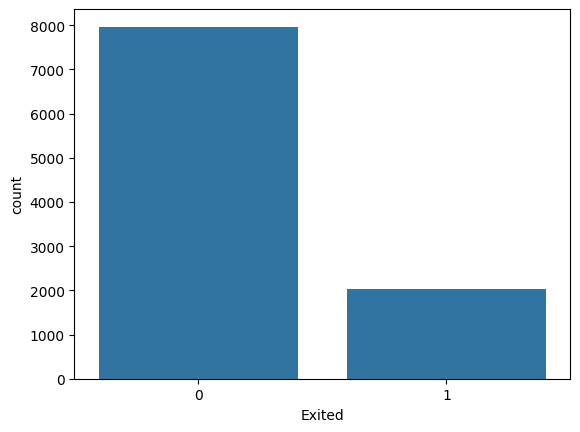

In [ ]:
ax = sns.countplot(x='Exited', data = dataset)

In [ ]:

#Descartando as colunas 'RowsNumber', 'CustumerId' e 'Surname', além de descartar as linhas com NaN
dataset = dataset.iloc[: , 3:]
dataset = dataset.dropna()

#Tranformação das feactures categoricas
column_transformer = make_column_transformer((OneHotEncoder(), ["Geography", "Gender"]), remainder='passthrough')
df = column_transformer.fit_transform(dataset)
colunas = column_transformer.get_feature_names_out()
dataset = pd.DataFrame(data = df, columns = colunas)

y = dataset['remainder__Exited']
X = dataset.drop('remainder__Exited', axis = 1)

#Normalização das feactures
colunas = X.columns
x = X.values
x_scale = MinMaxScaler().fit_transform(x)
X = pd.DataFrame(data = x_scale, columns = colunas)

X.head()

,onehotencoder__Geography_France,onehotencoder__Geography_Germany,onehotencoder__Geography_Spain,onehotencoder__Gender_Female,onehotencoder__Gender_Male,remainder__CreditScore,remainder__Age,remainder__Tenure,remainder__Balance,remainder__NumOfProducts,remainder__HasCrCard,remainder__IsActiveMember,remainder__EstimatedSalary
0,1.0,0.0,0.0,1.0,0.0,0.538,0.324324,0.2,0.000000,0.000000,1.0,1.0,0.506735
1,0.0,0.0,1.0,1.0,0.0,0.516,0.310811,0.1,0.334031,0.000000,0.0,1.0,0.562709
2,1.0,0.0,0.0,1.0,0.0,0.304,0.324324,0.8,0.636357,0.666667,1.0,0.0,0.569654
3,1.0,0.0,0.0,1.0,0.0,0.698,0.283784,0.1,0.000000,0.333333,0.0,0.0,0.469120
4,0.0,0.0,1.0,0.0,1.0,0.590,0.351351,0.8,0.453394,0.333333,1.0,0.0,0.748797


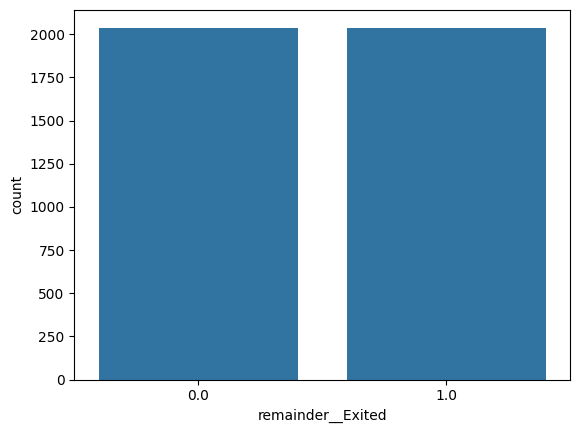

In [ ]:

nr = NearMiss()

X, y = nr.fit_resample(X,y)

ax = sns.countplot(x = y)

#Criação dos Folds

In [ ]:
#Quantidade de folds
folds = 10

#Função que recebe o X e o y e retorna as quatro listas com os folds de treinamento e de test
def generate_folds_lists(Features, Target):
  X_new = np.array(Features)
  y_new = np.array(Target)

  kf = StratifiedKFold(n_splits = folds)

  #Listas para as estratificações de treinamento e de teste
  X_train_list = []
  y_train_list = []

  X_test_list = []
  y_test_list = []

  #Gerando as estratificações
  for train_index, test_index in kf.split(X_new, y_new):
    X_train_list.append(X_new[train_index])
    X_test_list.append(X_new[test_index])

    y_train_list.append(y_new[train_index])
    y_test_list.append(y_new[test_index])

  return X_train_list, y_train_list, X_test_list, y_test_list

X_train, y_train, X_test, y_test = generate_folds_lists(X,y)


#Treinamento dos Modelos

## Primeiros modelos

In [ ]:
#Tupla com os nomes da métricas
metrics_tupla = ("accuracy", "precision", "recal", "specificity", "auc")

#modelo de dicinário com as métricas inicializadas
results = {"accuracy" : 0, "precision" : 0, "recal": 0, "specificity":0, "auc" : 0}


models_names = ["tree1", "tree2", "tree3", "knn1", "knn2", "knn3", "svm1", "svm2", "svm3", "gradientboosting", "xgboost", "lightgbm"]

# Criando O dicionário
models = {}

for model in models_names:
  models[model] = {}

##Definição dos parâmetros e dos tipos dos modelos

#Arvores de Decisão
models["tree1"]["params"] = {"max_depth" : 30}
models["tree1"]["type"] = 1
models["tree2"]["params"] = {"criterion" : "entropy", "max_depth" : 12}
models["tree2"]["type"] = 1
models["tree3"]["params"] = {"criterion" : 'log_loss', "max_depth" : 8, "max_features" : "sqrt"}
models["tree3"]["type"] = 1

#KNNs
models["knn1"]["params"] = {"n_neighbors" : 20, "metric" : 'euclidean'}
models["knn1"]["type"] = 2
models["knn2"]["params"] = {"weights" : 'distance', "algorithm" : 'brute'}
models["knn2"]["type"] = 2
models["knn3"]["params"] = {"n_neighbors" : 12, "weights" : 'distance'}
models["knn3"]["type"] = 2

#SVMs
models["svm1"]["params"] = {"kernel" : 'linear', "C" : 1.0}
models["svm1"]["type"] = 3
models["svm2"]["params"] = {"kernel" : "rbf", "gamma" : 0.7, "C" : 1.0}
models["svm2"]["type"] = 3
models["svm3"]["params"] = {"kernel" : "poly", "degree" : 2, "gamma" : "auto", "C" : 1.0}
models["svm3"]["type"] = 3

#Acrecimo dos modelos GradientBooting, XGBoost e LightGBM
models["gradientboosting"]["params"] = {"n_estimators" : 50}
models["gradientboosting"]["type"] = 4

models["xgboost"]["params"] = {}
models["xgboost"]["type"] = 5

models["lightgbm"]["params"] = {}
models["lightgbm"]["type"] = 6

for model in models_names:
  models[model]["metrics"] = results.copy()

#pprint.pp(models)

In [ ]:
models = super_function(models, models_names, False, X_train, y_train, X_test, y_test)


[LightGBM] [Info] Number of positive: 1834, number of negative: 1834
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 3668, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1834, number of negative: 1834
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 848
[LightGBM] [Info] Number of data points in the train set: 3668, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[L

In [ ]:
pprint.pp(models)

{'tree1': {'params': {'max_depth': 30},
           'type': 1,
           'metrics': {'accuracy': 0.6584899070193189,
                       'precision': 0.6555213269077286,
                       'recal': 0.6707910750507099,
                       'specificity': 0.6462160726359509,
                       'auc': 0.6585035738433305},
           'model': DecisionTreeClassifier(max_depth=30)},
 'tree2': {'params': {'criterion': 'entropy', 'max_depth': 12},
           'type': 1,
           'metrics': {'accuracy': 0.692334513658043,
                       'precision': 0.7272020244362353,
                       'recal': 0.6197720467497344,
                       'specificity': 0.7649787501207379,
                       'auc': 0.6923753984352362},
           'model': DecisionTreeClassifier(criterion='entropy', max_depth=12)},
 'tree3': {'params': {'criterion': 'log_loss',
                      'max_depth': 8,
                      'max_features': 'sqrt'},
           'type': 1,
           'metr

##RandomForest e Bagging

In [ ]:
forest_names = ["randomforest", "knorae", "knorau", "ola", "lca", "mcb"]

models_forest = {}
for model in forest_names:
  models_forest[model] = {}

models_forest["randomforest"]["params"] = {"n_estimators" : 50, "criterion" : "log_loss", "max_depth" : 8, "max_features" : "sqrt"}
models_forest["randomforest"]["type"] = 7

for model in forest_names:
  models_forest[model]["metrics"] = results.copy()
  if ( model != "randomforest"):
    models_forest[model]["params"] = {}


#pprint.pp(models_forest)

In [ ]:
models_forest = super_function(models_forest, forest_names, True, X_train, y_train, X_test, y_test)

In [ ]:
pprint.pp(models_forest)

{'randomforest': {'params': {'n_estimators': 50,
                             'criterion': 'log_loss',
                             'max_depth': 8,
                             'max_features': 'sqrt'},
                  'type': 7,
                  'metrics': {'accuracy': 0.7470479838126896,
                              'precision': 0.7861899585723959,
                              'recal': 0.6791244083840433,
                              'specificity': 0.8150053124698153,
                              'auc': 0.7470648604269294},
                  'model': RandomForestClassifier(criterion='log_loss', max_depth=8, n_estimators=50)},
 'knorae': {'metrics': {'accuracy': 0.6896619212795684,
                        'precision': 0.7196041232370413,
                        'recal': 0.631048971312663,
                        'specificity': 0.7483241572491065,
                        'auc': 0.6896865642808847},
            'params': {},
            'model': KNORAE(k=5,
       pool_classifiers

In [ ]:
bagging_names = ["bagging", "knorae", "knorau", "ola", "lca", "mcb"]

models_bagging = {}
for model in bagging_names:
  models_bagging[model] = {}

models_bagging["bagging"]["params"] = {"n_estimators" : 50}
models_bagging["bagging"]["type"] = 8

for model in bagging_names:
  models_bagging[model]["metrics"] = results.copy()
  if (model != "bagging"):
    models_bagging[model]["params"] = {}

#pprint.pp(models_bagging)

In [ ]:
models_bagging = super_function(models_bagging, bagging_names, True, X_train, y_train, X_test, y_test)

pprint.pp(models_bagging)

{'bagging': {'params': {'n_estimators': 50},
             'type': 8,
             'metrics': {'accuracy': 0.719339861251626,
                         'precision': 0.7375714627758914,
                         'recal': 0.6830508065295083,
                         'specificity': 0.7556674393895488,
                         'auc': 0.7193591229595288},
             'model': BaggingClassifier(n_estimators=50)},
 'knorae': {'metrics': {'accuracy': 0.7078088114852821,
                        'precision': 0.7247441627117543,
                        'recal': 0.6727470298464213,
                        'specificity': 0.7429006085192696,
                        'auc': 0.7078238191828455},
            'params': {},
            'model': KNORAE(k=5, pool_classifiers=BaggingClassifier(n_estimators=50))},
 'knorau': {'metrics': {'accuracy': 0.7198276485041192,
                        'precision': 0.7346522228627387,
                        'recal': 0.690406162464986,
                        'specificit

#Seleção de Features

<Axes: >

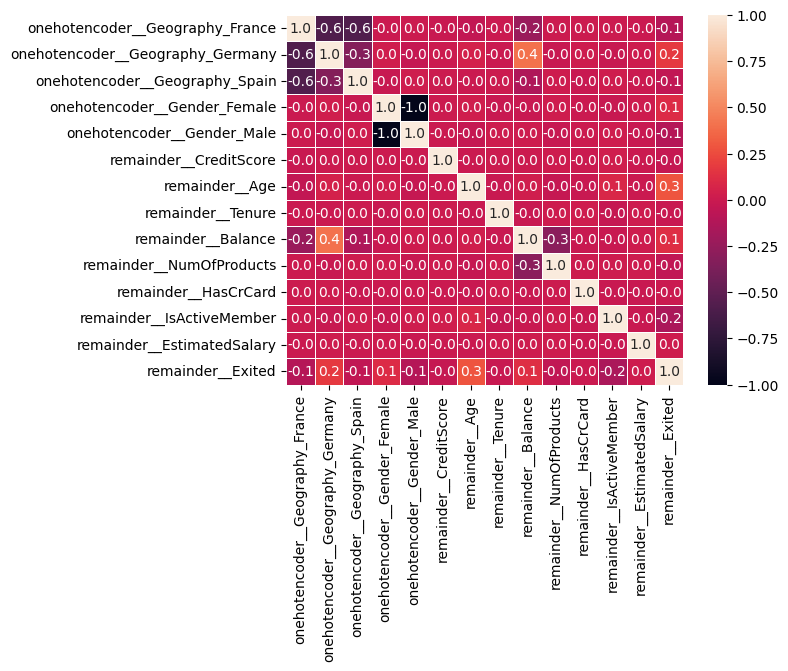

In [ ]:
correlation = dataset.corr()

plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)
plot

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

f_classiftest = SelectKBest(score_func=f_classif, k = 7)
modelofeat = f_classiftest.fit(X,y)

modelofeat.get_feature_names_out()

array(['onehotencoder__Geography_France',
       'onehotencoder__Geography_Spain', 'onehotencoder__Gender_Female',
       'onehotencoder__Gender_Male', 'remainder__Age',
       'remainder__NumOfProducts', 'remainder__HasCrCard'], dtype=object)

In [ ]:
#modelofeat.scores_

cols = modelofeat.get_support(indices=True)
x = X.iloc[:,cols]

train_X, train_y, test_X, test_y = generate_folds_lists(x,y)

In [ ]:
models_names_new = [models_names[i] + "_fselection" for i in range(len(models_names)) ]

models_new = {}
for model in models_names_new:
  models_new[model] = {}

#Arvores de Decisão
models_new["tree1_fselection"]["params"] = {"max_depth" : 30}
models_new["tree1_fselection"]["type"] = 1
models_new["tree2_fselection"]["params"] = {"criterion" : "entropy", "max_depth" : 12}
models_new["tree2_fselection"]["type"] = 1
models_new["tree3_fselection"]["params"] = {"criterion" : 'log_loss', "max_depth" : 8, "max_features" : "sqrt"}
models_new["tree3_fselection"]["type"] = 1

#KNNs
models_new["knn1_fselection"]["params"] = {"n_neighbors" : 20, "metric" : 'euclidean'}
models_new["knn1_fselection"]["type"] = 2
models_new["knn2_fselection"]["params"] = {"weights" : 'distance', "algorithm" : 'brute'}
models_new["knn2_fselection"]["type"] = 2
models_new["knn3_fselection"]["params"] = {"n_neighbors" : 12, "weights" : 'distance'}
models_new["knn3_fselection"]["type"] = 2

#SVMs
models_new["svm1_fselection"]["params"] = {"kernel" : 'linear', "C" : 1.0}
models_new["svm1_fselection"]["type"] = 3
models_new["svm2_fselection"]["params"] = {"kernel" : "rbf", "gamma" : 0.7, "C" : 1.0}
models_new["svm2_fselection"]["type"] = 3
models_new["svm3_fselection"]["params"] = {"kernel" : "poly", "degree" : 2, "gamma" : "auto", "C" : 1.0}
models_new["svm3_fselection"]["type"] = 3

#Acrecimo dos modelos GradientBooting, XGBoost e LightGBM
models_new["gradientboosting_fselection"]["params"] = {"n_estimators" : 50}
models_new["gradientboosting_fselection"]["type"] = 4

models_new["xgboost_fselection"]["params"] = {}
models_new["xgboost_fselection"]["type"] = 5

models_new["lightgbm_fselection"]["params"] = {}
models_new["lightgbm_fselection"]["type"] = 6

for model in models_names_new:
  models_new[model]["metrics"] = results.copy()

#pprint.pp(models_new)

In [ ]:
models_new = super_function(models_new, models_names_new, False, train_X, train_y, test_X, test_y)

[LightGBM] [Info] Number of positive: 1834, number of negative: 1834
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 3668, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1834, number of negative: 1834
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 68
[LightGBM] [Info] Number of data points in the train set: 3668, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[Light

In [ ]:
pprint.pp(models_new)

{'tree1_fselection': {'params': {'max_depth': 30},
                      'type': 1,
                      'metrics': {'accuracy': 0.7021498771498771,
                                  'precision': 0.7554527675893218,
                                  'recal': 0.5996112237998649,
                                  'specificity': 0.8047160243407707,
                                  'auc': 0.7021636240703176},
                      'model': DecisionTreeClassifier(max_depth=30)},
 'tree2_fselection': {'params': {'criterion': 'entropy', 'max_depth': 12},
                      'type': 1,
                      'metrics': {'accuracy': 0.7129516548634196,
                                  'precision': 0.7670997023661112,
                                  'recal': 0.6138438133874239,
                                  'specificity': 0.8120906983483049,
                                  'auc': 0.7129672558678644},
                      'model': DecisionTreeClassifier(criterion='entropy', max_depth

In [ ]:
forest_names_new = [forest_names[i]+"_fselection" for i in range(len(forest_names))]

#forest_names = ["randomforest", "knorae", "knorau", "ola", "lca", "mcb"]

models_forest_new = {}
for model in forest_names_new:
  models_forest_new[model] = {}

models_forest_new["randomforest_fselection"]["params"] = {"n_estimators" : 50, "criterion" : "log_loss", "max_depth" : 8, "max_features" : "sqrt"}
models_forest_new["randomforest_fselection"]["type"] = 7

for model in forest_names_new:
  models_forest_new[model]["metrics"] = results.copy()

#pprint.pp(models_forest_new)

In [ ]:
models_forest_new = super_function(models_forest_new, forest_names_new, True, train_X, train_y, test_X, test_y)

In [ ]:
pprint.pp(models_forest_new)

{'randomforest_fselection': {'params': {'n_estimators': 50,
                                        'criterion': 'log_loss',
                                        'max_depth': 8,
                                        'max_features': 'sqrt'},
                             'type': 7,
                             'metrics': {'accuracy': 0.7347768222768222,
                                         'precision': 0.777551633519538,
                                         'recal': 0.6585120254998551,
                                         'specificity': 0.8110885733603785,
                                         'auc': 0.7348002994301168},
                             'model': RandomForestClassifier(criterion='log_loss', max_depth=8, n_estimators=50)},
 'knorae_fselection': {'metrics': {'accuracy': 0.6896312087488558,
                                   'precision': 0.7057906757376505,
                                   'recal': 0.65406162464986,
                                   'speci

In [ ]:
bagging_names_new = [model+"_fselection" for model in bagging_names]

models_bagging_new = {}
for model in bagging_names_new:
  models_bagging_new[model] = {}

models_bagging_new["bagging_fselection"]["params"] = {"n_estimators" : 50}
models_bagging_new["bagging_fselection"]["type"] = 8

for model in bagging_names_new:
  models_bagging_new[model]["metrics"] = results.copy()

#pprint.pp(models_bagging)

In [ ]:
models_bagging_new = super_function(models_bagging_new, bagging_names_new, True, train_X, train_y, test_X, test_y)

In [ ]:
pprint.pp(models_bagging_new)

{'bagging_fselection': {'params': {'n_estimators': 50},
                        'type': 8,
                        'metrics': {'accuracy': 0.7063201570554513,
                                    'precision': 0.7347395585298933,
                                    'recal': 0.6481841012266976,
                                    'specificity': 0.764461991693229,
                                    'auc': 0.7063230464599632},
                        'model': BaggingClassifier(n_estimators=50)},
 'knorae_fselection': {'metrics': {'accuracy': 0.6695259430553547,
                                   'precision': 0.681492925355712,
                                   'recal': 0.6413310151646866,
                                   'specificity': 0.6977446150874144,
                                   'auc': 0.6695378151260504},
                       'model': KNORAE(k=5, pool_classifiers=BaggingClassifier(n_estimators=50))},
 'knorau_fselection': {'metrics': {'accuracy': 0.7019035746976924,
      

In [ ]:
#preencher os parametros como vazios para usar a função from_dict_to_mlflow()
for i in range (1,len(forest_names_new)):
  models_forest_new[forest_names_new[i]]["params"] = {}

#from_dict_to_mlflow(models_forest_new, forest_names_new)

#pprint.pp(models_forest_new)

In [ ]:
#preencher os parametros como vazios para usar a função from_dict_to_mlflow()
for i in range (1,len(bagging_names_new)):
  models_bagging_new[bagging_names_new[i]]["params"] = {}

#from_dict_to_mlflow(models_bagging_new, bagging_names_new)

#pprint.pp(models_forest_new)

#Parte do MLFlow

##Uso do NGROK e Criação do Cliente

In [ ]:
# 13) Rodar o NGROK e verificar os experimentos no tracking

get_ipython().system_raw("mlflow ui --port 5000 &")

ngrok.kill()

#Do meu ngrok
NGROK_AUTO_TOKEN = "2g9WABD6DYfhunX8dIZiwPDY7sd_22iCmbQAtyBfuMSu3jG7c"
ngrok.set_auth_token(NGROK_AUTO_TOKEN)

ngrok_tunel = ngrok.connect(addr = 5000, proto = 'http', bind_tls = True)
print("Endereço do MLflow: ", ngrok_tunel.public_url)

Endereço do MLflow:  https://f04f-34-73-80-87.ngrok-free.app


In [ ]:
from mlflow import MlflowClient

mlflow.set_tracking_uri(ngrok_tunel.public_url)

client= MlflowClient()

#Criação do Experimento
exp_id = client.create_experiment(
     name = "exp_projeto_ciclo_2",
     tags = {"versao":"v1", "prioridade":"P1"}
 )

#print('Experiment id', exp_id)

##Ranking das Melhores Acurácias

In [ ]:
ranking = {}

for model in models_names:
  ranking[model] = models[model]["metrics"]["accuracy"]

for model in forest_names:
  ranking[model] = models_forest[model]["metrics"]["accuracy"]

for model in bagging_names:
  ranking[model] = models_bagging[model]["metrics"]["accuracy"]

for model in models_names_new:
  ranking[model] = models_new[model]["metrics"]["accuracy"]

for model in forest_names_new:
  ranking[model] = models_forest_new[model]["metrics"]["accuracy"]

for model in bagging_names_new:
  ranking[model] = models_bagging_new[model]["metrics"]["accuracy"]

#pprint.pp(ranking)

sort_ranking = list(ranking.values())
sort_ranking.sort(reverse = True)

#for value in sort_ranking:
#  print(value)

sort_ranking = sort_ranking[:3]

pprint.pp(sort_ranking)


[0.7470479838126896, 0.7443434744905333, 0.7369863178686709]


In [ ]:
from mlflow.models.signature import ModelSignature, infer_signature
from mlflow.types.schema import Schema,ColSpec

#Criação da assinatura
def generate_signature(features):
  input_data = []
  for colum in features.columns:
    input_data.append({"name" : colum, "type" : "double"})

  output_data = [{"name" : "remainder__Exited", "type" : "integer"}]

  input_schema = Schema([ColSpec(col["type"], col['name']) for col in input_data])
  output_schema = Schema([ColSpec(col['type'], col['name']) for col in output_data])

  return ModelSignature(inputs=input_schema, outputs=output_schema)


In [ ]:
signature = generate_signature(X)
signature_fselection = generate_signature(x)

##Envio dos Modelos e Registros dos Melhores Modelos

In [ ]:
signed_models_names = []

def from_dict_to_mlflow(models_dic, names_models, sig):

  mlflow.end_run()

  for model in names_models:

    mlflow.start_run(run_name = model, experiment_id = exp_id)

    mlflow.log_params(models_dic[model]["params"])

    mlflow.log_metrics(models_dic[model]["metrics"])

    #Log do modelo
    if (models_dic[model]["metrics"]["accuracy"] in sort_ranking):
      mlflow.sklearn.log_model(models_dic[model]["model"], artifact_path=model+"-from_Project", registered_model_name= model+" - in Top 3", signature=sig)
      signed_models_names.append(model+" - in Top 3")
    else:
      mlflow.sklearn.log_model(models_dic[model]["model"], artifact_path=model+"-from_Project", signature=sig)

    mlflow.end_run()

In [ ]:
from_dict_to_mlflow(models, models_names, signature)

Successfully registered model 'gradientboosting - in Top 3'.
2024/06/07 00:05:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: gradientboosting - in Top 3, version 1
Created version '1' of model 'gradientboosting - in Top 3'.


In [ ]:
from_dict_to_mlflow(models_forest, forest_names, signature)

Successfully registered model 'randomforest - in Top 3'.
2024/06/07 00:05:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: randomforest - in Top 3, version 1
Created version '1' of model 'randomforest - in Top 3'.


In [ ]:
from_dict_to_mlflow(models_bagging, bagging_names, signature)

In [ ]:
from_dict_to_mlflow(models_new, models_names_new, signature_fselection)

Successfully registered model 'gradientboosting_fselection - in Top 3'.
2024/06/07 00:06:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: gradientboosting_fselection - in Top 3, version 1
Created version '1' of model 'gradientboosting_fselection - in Top 3'.


In [ ]:
from_dict_to_mlflow(models_forest_new, forest_names_new, signature_fselection)

In [ ]:
from_dict_to_mlflow(models_bagging_new, bagging_names_new, signature_fselection)

##Usando o Client Para Carregar os Modelos Registrados

In [ ]:
####### Alteração da descrição das versões dos modelos registrados
for name_model in signed_models_names:
  client.update_model_version(
    name = name_model,
    version="1",
    description="Esse modelo faz parte do Top 3 dos modelos com as melhores acurácias",
)

In [ ]:
#Código da documentação do MLFlow para capturar os models registrados juntamente com as respectivas informações

response = client.search_registered_models()

for res in response:
    for mv in res.latest_versions:
        print(f"name = {mv.name}; run_id = {mv.run_id}; version = {mv.version}")
        print(f"  Description = {mv.description}")
        print(f"  Source = ", mv.source)
        print("")

name = gradientboosting - in Top 3; run_id = a3f44ac387fe4b558080e784ad69c6d0; version = 1
  Description = Esse modelo faz parte do Top 3 dos modelos com as melhores acurácias
  Source =  mlflow-artifacts:/397491281902116845/a3f44ac387fe4b558080e784ad69c6d0/artifacts/gradientboosting-from_Project

name = gradientboosting_fselection - in Top 3; run_id = f5f05c831b814bd58cb1055a2a4f0aa2; version = 1
  Description = Esse modelo faz parte do Top 3 dos modelos com as melhores acurácias
  Source =  mlflow-artifacts:/397491281902116845/f5f05c831b814bd58cb1055a2a4f0aa2/artifacts/gradientboosting_fselection-from_Project

name = randomforest - in Top 3; run_id = 4e002e4cdefa4f3caad6d706110eb584; version = 1
  Description = Esse modelo faz parte do Top 3 dos modelos com as melhores acurácias
  Source =  mlflow-artifacts:/397491281902116845/4e002e4cdefa4f3caad6d706110eb584/artifacts/randomforest-from_Project



In [ ]:
## EXEMPLO DE CARREGAMENTO DO MODELO
modelNEW = mlflow.sklearn.load_model(model_uri="models:/"+signed_models_names[0]+"/1")
modelNEW.get_params()

#loaded_models = []
#for name in signed_modelss_names:
# loaded_models.append(mlflow.sklearn.load_model(model_uri="models:/"+name+"/1"))

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}